In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
texture_path = '/workspace/DECA/TestSamples/examples_head/jun_masked/jun_masked.png'

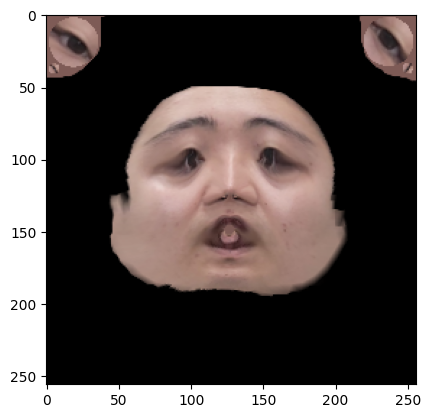

In [3]:
img = cv2.imread(texture_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(256, 256)


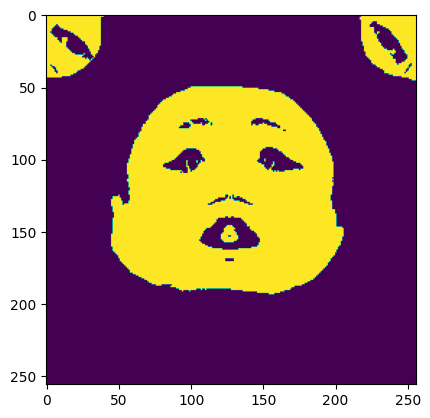

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

thresh = 255 - thresh
darkness = img.sum(axis=2) < 255 * 1.1
print(darkness.shape)
thresh[darkness] = 0
plt.imshow(thresh)

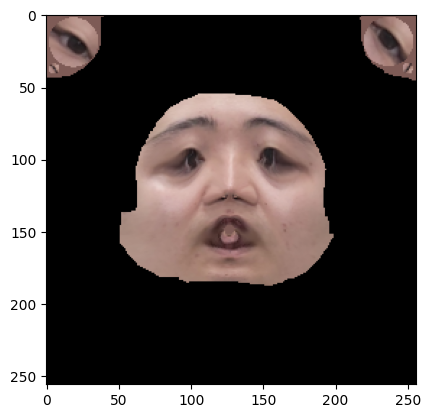

In [5]:
contours, hier = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
sorted_idx = sorted(range(len(contours)), key=lambda x: cv2.contourArea(contours[x]), reverse=True)

segment = np.zeros_like(img)

face_idx = sorted_idx[0]
cv2.drawContours(segment, contours, face_idx,color=(255,255,255),thickness=cv2.FILLED)

kernel = np.ones((3,3),np.uint8)
segment = cv2.erode(segment, kernel, iterations=5)

for i in sorted_idx[1:3]: # 1,2 -> eye segment
    cv2.drawContours(segment, contours, i,color=(255,255,255),thickness=cv2.FILLED)

plt.imshow(segment)

segment = segment.astype(bool)

g_img = np.zeros_like(img)

g_img[segment] = img[segment]

plt.imshow(g_img)

texture_region = segment.any(axis=2)

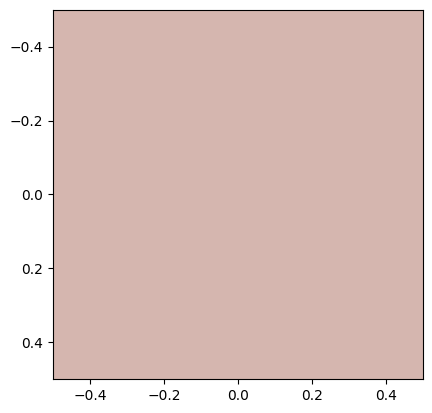

In [36]:
skin_img_path = '/workspace/DECA/TestSamples/examples_masked/jun_skin_only.png'
skin_img = cv2.imread(skin_img_path)

skin_hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)

skin_segment = skin_hsv[:, :, 2] > 0

skin_hsv = skin_hsv[skin_segment]
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(skin_hsv)

bright_idx = np.argmax(kmeans.cluster_centers_[:, 2])
bright_color = kmeans.cluster_centers_[bright_idx]

face_rgb = cv2.cvtColor(bright_color.reshape((1,1,3)).astype(np.uint8),cv2.COLOR_HSV2RGB)
plt.imshow(face_rgb)

## Texture Synthesis

In [37]:
contours, hier = cv2.findContours(texture_region.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
largest_idx = max(range(len(contours)), key=lambda x: cv2.contourArea(contours[x]))

begin_con = contours[largest_idx]

In [42]:
import queue

q = queue.Queue()

visited = texture_region.copy()

w, h = visited.shape

for p in begin_con:
    tuple_p = (p[0,1],p[0,0])
    q.put(tuple_p)

def get_adj_pixel(pos):
    dpos = [(pos[0] + dx, pos[1] + dy) for dx, dy in ((0,1), (0,-1), (1,0), (-1,0), (1,1), (1, -1), (-1,1), (-1, -1))]
    return filter(lambda x: 0 <= x[0] < w and 0 <= x[1] < h, dpos)

colors = []

num_layer = 0

while not q.empty():
    count = len(q.queue)

    for i in range(count):
        p = q.get()

        for adj_p in get_adj_pixel(p):
            if not visited[adj_p] and adj_p not in q.queue:
                q.put(adj_p)

        visited[p] = True

    num_layer += 1        

visited = texture_region.copy()

for p in begin_con:
    tuple_p = (p[0,1],p[0,0])
    q.put(tuple_p)

l = 0
while not q.empty():
    count = len(q.queue)
    
    if len(colors) > 0:
        mean_color = np.mean(colors, axis=0)
    else:
        mean_color = None

    colors = []
    for i in range(count):
        p = q.get()

        color = []
        for adj_p in get_adj_pixel(p):
            if not visited[adj_p] and adj_p not in q.queue:
                q.put(adj_p)
            
            if visited[adj_p]:
                color.append(g_img[adj_p])

        if mean_color is not None:
            t = (l / num_layer)
            g_img[p] = np.mean(color, axis=0) * 0.95 + mean_color * 0.02 + face_rgb * 0.03
        else:
            g_img[p] = np.mean(color, axis=0)
        
        colors.append(g_img[p])

        visited[p] = True
    l += 1

cv2.imwrite('jun_masked.png', cv2.cvtColor(g_img, cv2.COLOR_RGB2BGR))
# plt.imshow(g_img)

True

In [55]:
with open('temp.txt') as f:
    temp_content = f.readline()

flat_pos = list(map(float,temp_content.split()))

with open('temp2.txt') as f:
    temp_content = f.readline()

flat_idx = list(map(int,temp_content.split()))

with open('temp.obj', 'wt') as f:
    for x,y,z in np.array(flat_pos).reshape((-1,3)):
        f.write(f'v {x} {y} {z}\n')

    for v1,v2,v3 in np.array(flat_idx).reshape((-1.3)):
        f.write(f'f {v1} {v2} {v3}\n')